In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
from omegaconf import OmegaConf
from cmass.infer.loaders import get_cosmo
wdir = '/ocean/projects/phy240015p/mho1/cmass-ili'

nbody = 'quijote'
sim = 'nonoise'
L, N = 1000, 128
lhid = 663  # 663

simdir = join(wdir, nbody, sim, f'L{L:d}-N{N:d}', str(lhid))

# cosmo = get_cosmo(simdir)
cfg = OmegaConf.load(join(simdir, 'config.yaml'))

In [4]:
# Load observations
from cmass.survey.tools import sky_to_xyz
from cmass.survey.tools import in_simbig_selection
cosmo = Planck18


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = 0.4, 0.7
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

# # Load NGC
# fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
# cmass = load_fits(fname, fields)
# nrdz = cmass[['RA', 'DEC', 'Z']].values
# mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
# nrdz = nrdz[mask]
# nxyz = sky_to_xyz(nrdz, cosmo)


# Load SGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
cmass = load_fits(fname, fields)
srdz = cmass[['RA', 'DEC', 'Z']].values
mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
srdz = srdz[mask]

mask = in_simbig_selection(srdz[:, 0], srdz[:, 1], srdz[:, 2])
srdz = srdz[mask]

sxyz = sky_to_xyz(srdz, cosmo)

In [5]:
# load lightcone
hodseed = lhid*10+1
filename = join(simdir, 'simbig_lightcone', f'hod{hodseed:05d}_aug{0:05d}.h5')
with h5py.File(filename, 'r') as f:
    ra, dec, z = f['ra'][:], f['dec'][:], f['z'][:]
    rdz = np.stack((ra, dec, z), axis=-1)
xyz = sky_to_xyz(rdz, cosmo)
# xyz = xyz[xyz[:, -1] < 1000]

In [6]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Convex hull for xyz
hull_xyz = ConvexHull(xyz)
hull_xyz_delaunay = Delaunay(xyz[hull_xyz.vertices])

# Identify which sxyz points are *outside* the convex hull
inside_mask = hull_xyz_delaunay.find_simplex(sxyz) >= 0
outside_points = sxyz[~inside_mask]
inside_points = sxyz[inside_mask]

print(f"{np.sum(~inside_mask)} out of {len(sxyz)} sxyz points are outside the xyz hull.")
percent_inside = np.sum(inside_mask) / len(sxyz) * 100
print(f"{percent_inside:.4f}% of sxyz points are inside the xyz hull.")

995 out of 109636 sxyz points are outside the xyz hull.
99.0925% of sxyz points are inside the xyz hull.


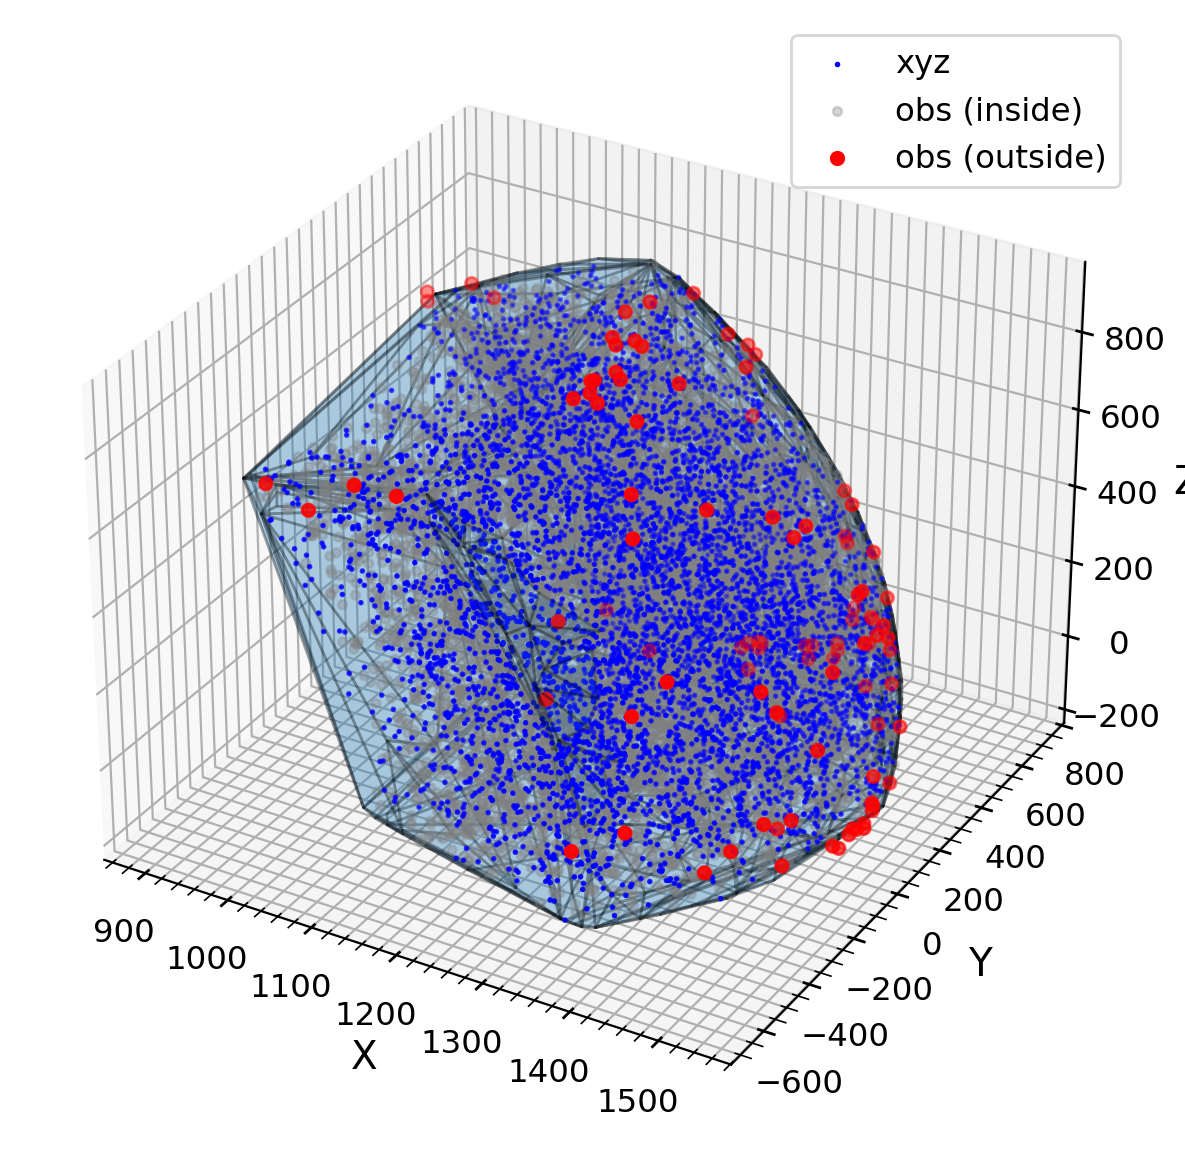

In [8]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot hull of xyz
for simplex in hull_xyz.simplices:
    tri = Poly3DCollection([xyz[simplex]], alpha=0.2)
    tri.set_edgecolor("k")
    ax.add_collection3d(tri)

# Plot xyz and sxyz
ss = 10
ax.scatter(*xyz[::ss].T, color="blue", label="xyz", s=1)
ax.scatter(*inside_points[::ss].T, color="gray",
           label="obs (inside)", s=10, alpha=0.3)
if len(outside_points) > 0:
    ax.scatter(*outside_points[::ss].T, color="red",
               label="obs (outside)", s=20)
ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.tight_layout()

# ax.view_init(elev=0, azim=-90)

plt.show()